1. **Analyze common patterns**: similarities among misclassified instances, such as specific words, phrases, or topics that are causing confusion for the model.  

    -**Group instances by misclassification type or class**: Categorize the misclassified instances based on the types of errors made by your model or the classes to which they belong. 
    
    -**Examine feature distribution**: Analyze the distribution of features, words, or phrases in the misclassified instances. Look for patterns that are unique or more prevalent in the misclassified instances compared to correctly classified instances.  
   
   -**Visualize common patterns**: Create visualizations, such as word clouds, bar charts, or heatmaps, frequency analysis, or TF-IDF scores to highlight the important words, to visually represent the frequency or distribution of features within the misclassified instances. This can help identify common patterns more intuitively.  
   
   -**Compare with correctly classified instances**: Compare the frequency or occurrence of the features, words, or phrases in the misclassified instances with their counterparts in the correctly classified instances of the same class. This will help identify the distinguishing factors that contribute to misclassifications.
       
   -**Use statistical analysis techniques**: Apply statistical techniques, such as hypothesis testing or correlation analysis, to determine if there are significant associations or relationships between certain features and misclassifications.


2. Identify **sources of errors**. Common sources of errors include ambiguous or noisy data, class imbalance, domain-specific language, or limitations in the model's representation or training.


3. **Explore feature importance**: Analyze the importance of different features or words in the misclassified instances. Feature importance techniques such as permutation importance, information gain, or coefficient analysis can provide insights into the features that contribute most to misclassifications.


4. Determine actionable insights: how to improve the model? data preprocessing techniques, feature engineering, addressing class imbalance, modifying the model architecture, or adjusting hyperparameters.


5. Iterate and improve.

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline

import random
from collections import Counter
from nltk import ngrams
import nltk
from scipy.sparse import hstack
import gensim
from gensim.models import Word2Vec, KeyedVectors
from nltk import word_tokenize

In [5]:
df = pd.read_csv("D:\\MS DATA SCIENCE\\NLP TESE\\data\\data_processed_selected.csv")
df.head()

,date,title,reason,description,zone,narrative_tfidf,narrative_embeddings,narrative_bert,narrative_tfidf_title,narrative_bert_title,...,tfidf_title,title_tfidf_nolemma,events,keywords,locs,embeddings_title,tfidf_keywords,embeddings_keywords,events_clean,events_tfidf
0,2021-10-11 12:26:32,CTT - Encomenda entregue danificada e com etiq...,0,Bom dia venho por este meio apresentar uma rec...,Lisboa,bom dia venho meio apresentar reclamação ctt e...,bom dia venho por este meio apresentar uma rec...,Bom dia venho por este meio apresentar uma rec...,ctt encomenda entregar danificar etiqueta envi...,ctt - encomenda entregue danificada e com etiq...,...,ctt encomenda entregar danificar etiqueta envi...,ctt encomenda entregue danificada etiquetas en...,"['venho', 'apresentar', 'Enviei', 'destinado',...",apresentar uma reclamação tinha caixa figura e...,"['Israel', 'Aboboda', 'Israel', 'de Braga', 'O...",ctt - encomenda entregue danificada e com etiq...,apresentar reclamação caixa figura envio israe...,apresentar uma reclamação tinha caixa figura e...,venho apresentar enviei destinado feito proteg...,quase destruir figura partida chegar Caixa che...
1,2021-08-31 23:20:15,CTT - Carta com certificado rasgado!,1,- Boa Noite!\r\n\r\n- Venho por este meio recl...,Coimbra,bom noite venho meio reclamar data ás durante ...,- boa noite!\r\n\r\n- venho por este meio recl...,- Boa Noite! Venho por este meio reclamar que ...,ctt carta certificar rasgar bom noite venho me...,ctt - carta com certificado rasgado! - Boa No...,...,ctt carta certificar rasgar,ctt carta certificado rasgado,"['Venho', 'reclamar', 'deparei -me', 'continha...",Lilia Pimentel certificado profissional passag...,['Boa Noite!'],ctt - carta com certificado rasgado !,lilia pimentel certificar profissional passage...,lilia pimentel certificado profissional passag...,venho reclamar deparei -me continha tem,NaN
2,2021-02-01 19:08:32,CTT - Encomenda registada que nunca chegou ao ...,2,"Boa tarde,\r\nNo dia 17 de Dezembro de 2020 en...",Aveiro,bom tarde dia dezembro enviar encomenda França...,"boa tarde,\r\nno dia 00 de dezembro de 0000 en...","Boa tarde, No dia 17 de Dezembro de 2020 envie...",ctt encomenda registar nunca chegar destine o ...,ctt - encomenda registada que nunca chegou ao ...,...,ctt encomenda registar nunca chegar destine o,ctt encomenda registada nunca chegou destino,"['enviei', 'registado', 'vejo', 'chegou', 'sai...",França em correio registado França em correio ...,"['França', 'Roissy', 'ROISSY']",ctt - encomenda registada que nunca chegou ao ...,frança correio registar frança correio encomen...,frança em correio registado frança em correio ...,enviei registado vejo chegou saiu chegou tem p...,resolr
3,2018-04-19 09:04:34,CTT - Correio Verde,2,"Bom dia,\n\nPretendia esclarecer uma situação ...",Lisboa,bom dia pretender esclarecer situação ocorrer ...,"bom dia,\n\npretendia esclarecer uma situação ...","Bom dia, Pretendia esclarecer uma situação que...",ctt correio verde bom dia pretender esclarecer...,"ctt - correio verde Bom dia, Pretendia esclar...",...,ctt correio verde,ctt correio verde,"['Pretendia esclarecer', 'ocorreu', 'desloquei...",Pretendia esclarecer uma situação Pretendia es...,['Lisboa'],ctt - correio verde,pretender esclarecer situação pretender esclar...,pretendia esclarecer uma situação pretendia es...,pretendia esclarecer ocorreu desloquei dado fe...,esclarecer saber semana enviar eventualmente a...
4,2019-07-04 10:20:41,"CTT - Aviso de recepção da carta registada, pr...",2,venho por este meio solicitar a vossa ajuda pa...,Porto,venho meio solicitar vosso ajudar saber onde e...,venho por este meio solicitar a vossa ajuda pa...,venho por este meio solicitar a vossa ajuda pa...,ctt aviso recepção carta registar preciso urge...,"ctt - aviso de recepção da carta registada, pr...",...,ctt aviso recepção carta registar preciso urge...,ctt aviso recepção carta registada preciso urg...,"['venho', 'solicitar', 'saber onde se encontra...",papais para o centro 

## Error analysis of best models tf-idf (linear svc, concatenating description+title)

In [83]:
def misclassifications(df, clf):
    df['tfidf_title'] = df['tfidf_title'].fillna('')
    df['narrative_tfidf'] = df['narrative_tfidf'].fillna('')

    # Split data into train, validation and test sets
    X_train, X_test, y_train, y_test = train_test_split(df, df['reason'], test_size=0.3, stratify=df['reason'], random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)
    
    # Concatenate the 'title' and 'description' columns
    X_train_text = X_train['tfidf_title'] + ' ' + X_train['narrative_tfidf']
    X_val_text = X_val['tfidf_title'] + ' ' + X_val['narrative_tfidf']

    # Define the tf-idf vectorizer for the concatenated text
    vectorizer = TfidfVectorizer(ngram_range=(1,3), max_df=0.95, min_df=2)
    X_train_tfidf = vectorizer.fit_transform(X_train_text)
    X_val_tfidf = vectorizer.transform(X_val_text)

    # Train and predict with classifier
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_val_tfidf)

    # evaluation metrics
    confusion_mat = confusion_matrix(y_true=y_val, y_pred=y_pred, labels=[0,1,2,3])
    class_rep= classification_report(y_val, y_pred)
    print(class_rep)
    
    # Print the confusion matrix using Matplotlib
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confusion_mat.shape[0]):
        for j in range(confusion_mat.shape[1]):
            ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Actuals', fontsize=12)
    plt.title('Confusion Matrix of {}'.format(clf), fontsize=12)
    plt.show()
    print('\n')

    results_df = pd.DataFrame({'Text': df.loc[y_val.index, 'tfidf_title']+ ' ' + df.loc[y_val.index, 'narrative_tfidf'],
                               'Orginal text':df.loc[y_val.index, 'title']+ ' ' + df.loc[y_val.index, 'narrative_bert'],
                               'Predicted Label': y_pred,
                               'True Label': y_val})

    misclassified_texts = results_df[results_df['Predicted Label'] != results_df['True Label']]
    correctly_classified = results_df[results_df['Predicted Label'] == results_df['True Label']]
    
    return misclassified_texts, correctly_classified

              precision    recall  f1-score   support

           0       0.60      0.68      0.63      1195
           1       0.34      0.10      0.15       333
           2       0.75      0.83      0.79      1609
           3       0.50      0.26      0.34       227

    accuracy                           0.67      3364
   macro avg       0.54      0.47      0.48      3364
weighted avg       0.64      0.67      0.64      3364



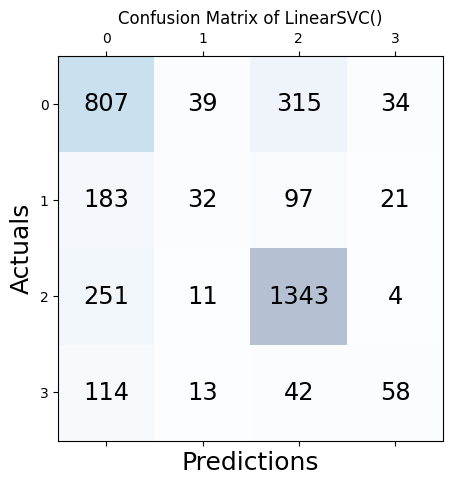

In [84]:
misclassified_svc, correctly_classified_svc=misclassifications(df, LinearSVC())

In [85]:
# true label is zero but it was classified as something else
class_0 = misclassified_svc[misclassified_svc['True Label'] == 0]
# true label is 1 but it was classified as somthing else,...
class_1 = misclassified_svc[misclassified_svc['True Label'] == 1]
class_2 = misclassified_svc[misclassified_svc['True Label'] == 2]
class_3 = misclassified_svc[misclassified_svc['True Label'] == 3]

In [86]:
# true label is zero and it was classified as zero
class_00 = correctly_classified_svc[correctly_classified_svc['True Label'] == 0]
# true label is 1 and it was classified as 1,...
class_11 = correctly_classified_svc[correctly_classified_svc['True Label'] == 1]
class_22 = correctly_classified_svc[correctly_classified_svc['True Label'] == 2]
class_33 = correctly_classified_svc[correctly_classified_svc['True Label'] == 3]

In [88]:
def top_features(texts, top):
    texts = texts['Text'].tolist()

    # Tokenize the text into words or phrases
    tokens = [word for text in texts for word in text.split()]

    # Create bigrams and trigrams
    unigrams = list(ngrams(tokens, 1))
    bigrams = list(ngrams(tokens, 2))
    trigrams = list(ngrams(tokens, 3))

    # Count the frequency of each bigram and trigram
    unigram_freq = Counter(unigrams)
    bigram_freq = Counter(bigrams)
    trigram_freq = Counter(trigrams)

    # Sort the frequencies in descending order
    sorted_unigram_freq = sorted(unigram_freq.items(), key=lambda x: x[1], reverse=True)
    sorted_bigram_freq = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)
    sorted_trigram_freq = sorted(trigram_freq.items(), key=lambda x: x[1], reverse=True)

    # Get the top bigrams and trigrams
    top_unigrams = dict(sorted_unigram_freq[:top])
    top_bigrams = dict(sorted_bigram_freq[:top])
    top_trigrams = dict(sorted_trigram_freq[:top])

    # Create a DataFrame
    df_top_features = pd.DataFrame({'Unigrams': list(top_unigrams.keys()),
                                    'Bigrams': list(top_bigrams.keys()),
                                    'Trigrams': list(top_trigrams.keys())})

    # Display the DataFrame
    return df_top_features

In [89]:
class_0_texts = class_0['Text'].tolist()
class_1_texts = class_1['Text'].tolist()
class_2_texts = class_2['Text'].tolist()
class_3_texts = class_3['Text'].tolist()
class_00_texts = class_00['Text'].tolist()
class_11_texts = class_11['Text'].tolist()
class_22_texts = class_22['Text'].tolist()
class_33_texts = class_33['Text'].tolist()

# Concatenate the texts from different classes
corpus_wrong = class_0_texts + class_1_texts + class_2_texts + class_3_texts
corpus_right = class_00_texts + class_11_texts + class_22_texts + class_33_texts

In [90]:
def tfidf_scores(corpus, top):
    # Create an instance of TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_df=0.95, min_df=2)

    # Fit and transform the corpus to compute TF-IDF scores
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

    # Get the feature names (words)
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Extract the TF-IDF scores for class 0
    class_0_tfidf_scores = tfidf_matrix[:len(class_0_texts), :]
    class_1_tfidf_scores = tfidf_matrix[len(class_0_texts):len(class_0_texts)+len(class_1_texts), :]
    class_2_tfidf_scores = tfidf_matrix[len(class_0_texts)+len(class_1_texts):len(class_0_texts)+len(class_1_texts)+len(class_2_texts), :]
    class_3_tfidf_scores = tfidf_matrix[len(class_0_texts)+len(class_1_texts)+len(class_2_texts):, :]
    

    # Retrieve the top N words/features for each class
    top_n = top  # Number of top words/features to retrieve
    # Retrieve the top words/features for class 0
    class_0_top_words = [feature_names[idx] for idx in class_0_tfidf_scores.indices[np.argsort(-class_0_tfidf_scores.data)[:top_n]]]
    class_1_top_words = [feature_names[idx] for idx in class_1_tfidf_scores.indices[np.argsort(-class_1_tfidf_scores.data)[:top_n]]]
    class_2_top_words = [feature_names[idx] for idx in class_2_tfidf_scores.indices[np.argsort(-class_2_tfidf_scores.data)[:top_n]]]
    class_3_top_words = [feature_names[idx] for idx in class_3_tfidf_scores.indices[np.argsort(-class_3_tfidf_scores.data)[:top_n]]]
    
    # Create a DataFrame
    df_top_words = pd.DataFrame({'class_0_top_words': class_0_top_words,
                                'class_1_top_words': class_1_top_words,
                                'class_2_top_words': class_2_top_words,
                                'class_3_top_words': class_3_top_words})

    # Display the DataFrame
    return df_top_words
    

### class 0 - Mau Serviço Prestado  
 true label 0 but classified as something else

In [92]:
# left 3 top features of texts with true label 0 but classified as smtg else
# right 3 top features of texts with true label 0 that were classified 0
concatenated_df = pd.concat([top_features(class_0, 20), top_features(class_00, 20)], axis=1)
concatenated_df

,Unigrams,Bigrams,Trigrams,Unigrams,Bigrams,Trigrams
0,"(encomenda,)","(ctt, encomenda)","(ctt, encomenda, entregar)","(ctt,)","(Caixa, correio)","(ctt, encomenda, entregar)"
1,"(ctt,)","(de, este)","(chegar, destine, o)","(encomenda,)","(de, este)","(mau, serviço, prestar)"
2,"(dia,)","(encomenda, entregar)","(fw, desalfandegamento, suspender)","(entregar,)","(ctt, encomenda)","(aviso, Caixa, correio)"
3,"(entregar,)","(destine, o)","(em, este, momento)","(dia,)","(entregar, encomenda)","(serviço, prestar, ctt)"
4,"(enviar,)","(em, este)","(bom, tarde, venho)","(correio,)","(em, este)","(em, este, momento)"
5,"(correio,)","(bom, tarde)","(ter, ser, entregar)","(serviço,)","(tocar, campainha)","(venho, meio, reclamar)"
6,"(fazer,)","(desde, dia)","(aguardar, procedimento, declarativo)","(fazer,)","(encomenda, entregar)","(de, este, vez)"
7,"(chegar,)","(entregar, encomenda)","(ticket, fw, desalfandegamento)","(ter,)","(serviço, prestar)","(chegar, destine, o)"
8,"(resposta,)","(venho, meio)","(venho, meio, reclamar)","(vez,)","(venho, meio)","(em, esse, dia)"
9,"(receber,)","(enviar, encomenda)","(lembrar, qualquer, informação)","(ir,)","(mau, serviço)","(poder, fazer, nada)"


In [96]:
# left 4 : features with highest tf-idf score for misclassified texts for each class
# right 4 : features with highest tf-idf score for correctly classified texts for each class
concatenated_df = pd.concat([tfidf_scores(corpus_wrong, 20), tfidf_scores(corpus_right, 20)], axis=1)
concatenated_df

,class_0_top_words,class_1_top_words,class_2_top_words,class_3_top_words,class_0_top_words,class_1_top_words,class_2_top_words,class_3_top_words
0,publicação,iva,pensão,item,máquina,recolha,terra,revista
1,wish,diploma,faturação,eur,cacifo,freguesia,the,itália
2,jornal,garrafa,notificar,envelope,pacote,cacifo,subsidio,revista
3,objeto postal,revista,iban,portagem,objecto devolver,produto,quadro,transitr
4,português,imt,objeto,postnl,at,artigo,envelope,remessa
5,iva,cheque,nao,vale,certificado,frágil,espanha,santarém
6,portugal chegar portugal,urbanização,pintura,cópia,peça,cobranca,rádio,volume
7,país destine,amiga,fev,pin,carta,almada,frasco,pacote correio
8,aplicacao,dobrar,chegar devir,número,aviso receção,vale,cancelamento,en
9,moreira,dificuldade,peça,pouco euro,disco,net,auto,pacote


### class 1 - Condições de entrega
 true label 1 but classified as something else

In [93]:
# left 3 top features of texts with true label 1 but classified as smtg else
# right 3 top features of texts with true label 1 that were classified 1
concatenated_df = pd.concat([top_features(class_1, 20), top_features(class_11, 20)], axis=1)
concatenated_df

,Unigrams,Bigrams,Trigrams,Unigrams,Bigrams,Trigrams
0,"(encomenda,)","(Caixa, correio)","(ctt, encomenda, entregar)","(encomenda,)","(Caixa, correio)","(passar, dia, entregar)"
1,"(ctt,)","(ctt, encomenda)","(chegar, destine, o)","(entregar,)","(ctt, encomenda)","(entregar, recetaculo, postal)"
2,"(entregar,)","(entregar, encomenda)","(aviso, Caixa, correio)","(ctt,)","(enviar, encomenda)","(ctt, encomenda, entregar)"
3,"(dia,)","(de, este)","(ctt, entregar, encomenda)","(Caixa,)","(levantar, encomenda)","(em, este, caso)"
4,"(correio,)","(encomenda, entregar)","(encomenda, dar, entregar)","(correio,)","(em, este)","(dia, entregar, recetaculo)"
5,"(fazer,)","(receber, encomenda)","(deixar, Caixa, correio)","(envelope,)","(entregar, encomenda)","(recetaculo, postal, encomenda)"
6,"(ir,)","(bom, tarde)","(venho, meio, reclamar)","(dia,)","(de, este)","(postal, encomenda, numero)"
7,"(enviar,)","(tocar, campainha)","(de, este, vez)","(enviar,)","(encomenda, entregar)","(encomenda, numero, rastreio)"
8,"(ter,)","(enviar, encomenda)","(ter, ser, entregar)","(poder,)","(passar, dia)","(numero, rastreio, todo)"
9,"(vez,)","(em, este)","(bom, tarde, venho)","(danificar,)","(dia, entregar)","(rastreio, todo, encomenda)"


### class 2 - Atraso de entrega
 true label 2 but classified as something else

In [94]:
# left 3 top features of texts with true label 2 but classified as smtg else
# right 3 top features of texts with true label 2 that were classified 2
concatenated_df = pd.concat([top_features(class_2, 20), top_features(class_22, 20)], axis=1)
concatenated_df

,Unigrams,Bigrams,Trigrams,Unigrams,Bigrams,Trigrams
0,"(ctt,)","(de, este)","(ctt, encomenda, entregar)","(encomenda,)","(ctt, encomenda)","(ctt, atraso, entregar)"
1,"(encomenda,)","(ctt, encomenda)","(venho, meio, reclamar)","(dia,)","(desde, dia)","(chegar, destine, o)"
2,"(dia,)","(em, este)","(serviço, prestar, ctt)","(ctt,)","(bom, tarde)","(ctt, encomenda, entregar)"
3,"(entregar,)","(encomenda, entregar)","(chegar, Portugal, dia)","(entregar,)","(de, este)","(aguardar, procedimento, declarativo)"
4,"(serviço,)","(entregar, encomenda)","(em, este, momento)","(enviar,)","(destine, o)","(venho, meio, reclamar)"
5,"(enviar,)","(serviço, ctt)","(chegar, destine, o)","(chegar,)","(entregar, encomenda)","(chegar, Portugal, dia)"
6,"(fazer,)","(bom, tarde)","(em, esse, dia)","(ainda,)","(passar, dia)","(atraso, entregar, encomenda)"
7,"(ter,)","(ter, ser)","(em, este, caso)","(correio,)","(ctt, atraso)","(ter, ser, entregar)"
8,"(reclamação,)","(Caixa, correio)","(encomenda, chegar, Portugal)","(ter,)","(dia, dezembro)","(ctt, encomenda, retir)"
9,"(vez,)","(passar, dia)","(encomenda, entregar, bom)","(fazer,)","(hoje, dia)","(bom, tarde, venho)"


### class 3 - Enganos 
 true label 3 but classified as something else

In [95]:
# left 3 top features of texts with true label 3 but classified as smtg else
# right 3 top features of texts with true label 3 that were classified 3
concatenated_df = pd.concat([top_features(class_3, 20), top_features(class_33, 20)], axis=1)
concatenated_df

,Unigrams,Bigrams,Trigrams,Unigrams,Bigrams,Trigrams
0,"(encomenda,)","(ctt, encomenda)","(ctt, encomenda, entregar)","(encomenda,)","(ctt, encomenda)","(ctt, encomenda, entregar)"
1,"(ctt,)","(encomenda, entregar)","(chegar, destine, o)","(entregar,)","(encomenda, entregar)","(entregar, morada, errar)"
2,"(entregar,)","(destine, o)","(Código, Código, Código)","(ctt,)","(ser, entregar)","(errar, bom, tarde)"
3,"(dia,)","(Caixa, correio)","(Cttcd, ctt, portagem)","(morada,)","(entregar, encomenda)","(nome, morada, destinatário)"
4,"(morada,)","(venho, meio)","(ctt, portagem, matricular)","(dia,)","(entregar, morada)","(encomenda, entregar, morada)"
5,"(correio,)","(de, este)","(portagem, matricular, ficar)","(valor,)","(nome, morada)","(encomenda, ser, entregar)"
6,"(ter,)","(ter, ser)","(matricular, ficar, saldo)","(ser,)","(morada, errar)","(em, este, momento)"
7,"(enviar,)","(ser, entregar)","(ficar, saldo, cartoes)","(ver,)","(bom, tarde)","(entregar, encomenda, morada)"
8,"(ser,)","(dever, ter)","(saldo, cartoes, usar)","(resposta,)","(errar, bom)","(ter, ser, entregar)"
9,"(valor,)","(bom, tarde)","(cartoes, usar, recibos)","(bom,)","(de, este)","(ctt, entregar, encomenda)"


## Error analysis best embeddings w2v (linear svc, not concatenating description+title)

In [32]:
w2v= KeyedVectors.load_word2vec_format('D:\\MS DATA SCIENCE\\NLP TESE\\embeddings\\skip_s600_word2vec.txt')

In [33]:
def e_misclassifications(df, emb, clf):
    X=df[['narrative_embeddings','embeddings_title']]
    y=df['reason']

    # Split data into train, validation and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

    import warnings
    warnings.filterwarnings("ignore")
    # Obtain embeddings for each split
    #Xtrain
    title_embeddings_train = getVectors(X_train['embeddings_title'], emb, 600)  # Column index 1 corresponds to 'embeddings_title'
    description_embeddings_train = getVectors(X_train['narrative_embeddings'], emb, 600)  # Column index 0 corresponds to 'narrative_embeddings'
    #Xval
    title_embeddings_val = getVectors(X_val['embeddings_title'], emb, 600)
    description_embeddings_val = getVectors(X_val['narrative_embeddings'], emb, 600)
    #concatenate them
    X_train_combined = np.concatenate((description_embeddings_train, title_embeddings_train), axis=1)
    X_val_combined = np.concatenate((description_embeddings_val, title_embeddings_val), axis=1)

    # Train and predict with classifier
    clf.fit(X_train_combined, y_train)
    y_pred = clf.predict(X_val_combined)

    # evaluation metrics
    confusion_mat = confusion_matrix(y_true=y_val, y_pred=y_pred, labels=[0,1,2,3])
    class_rep= classification_report(y_val, y_pred)
    print(class_rep)
    print(confusion_mat)

    original_text = df.loc[y_val.index, ['title', 'narrative_bert']]
    results_df = pd.DataFrame({'Original Title': original_text['title'],
                               'Original Narrative': original_text['narrative_bert'],
                               'Predicted Label': y_pred,
                               'True Label': y_val})

    misclassified_texts = results_df[results_df['Predicted Label'] != results_df['True Label']]
    
    return misclassified_texts

In [34]:
misclassified_texts=e_misclassifications(df, w2v, LinearSVC())

NameError: name 'getVectors' is not defined

In [ ]:
misclassified_texts

In [ ]:
samples_lsvc = misclassified_texts.sample(100)
print('MISCLASSIFIED best w2v LSVC TEXTS')
for i in range(100):
    print(samples_lsvc['Original Title'].iloc[i]+ ' '+ samples_lsvc['Original Narrative'].iloc[i])
    print('TRUE LABEL IS {} BUT IT WAS CLASSIFIED AS {}'.format(samples_lsvc['True Label'].iloc[i],
                                                                samples_lsvc['Predicted Label'].iloc[i]))
    print('\n')